In [1]:
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.datasets.base import Bunch
from sklearn.impute import SimpleImputer

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

%matplotlib inline

In [2]:
# load patient data
import pickle
from sklearn.datasets.base import Bunch

folder_path = '../../../datalcdem/data/optima/dementia_18July/class_mild_mod_sev/'

d = pickle.load(open(folder_path + 'patient_data.pkl', 'rb'))

patient_data =  Bunch(data=d['data'], target=d['target'], target_name=d['target_names'], target_real=d['target_real'])

data_p = patient_data.data
target_p = patient_data.target
target_real_p = patient_data.target_real
target_names_p = patient_data.target_name
display(data_p.shape, target_p.shape, target_real_p.shape, target_names_p.shape, data_p[0:5], target_p[0:5], target_real_p[0:5], target_names_p[0:5])

(130, 655)

(130,)

(130,)

(130,)

array([[ 0.,  1.,  0., ...,  0.,  0., 59.],
       [ 0.,  1.,  0., ..., nan, nan, nan],
       [ 0.,  1.,  0., ..., nan, nan, nan],
       [ 0.,  1.,  1., ..., nan, nan, nan],
       [ 0.,  1.,  0., ...,  0.,  0., 66.]])

array([2, 5, 3, 4, 0])

array([2, 5, 3, 4, 0])

array(['Normal', 'Fast_MiS', 'Normal_MiS', 'Fast', 'Slow'], dtype=object)

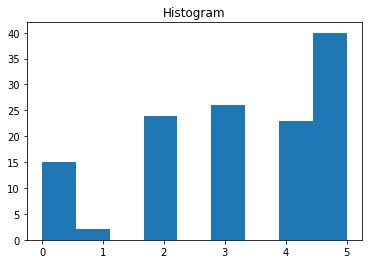

In [3]:
import matplotlib.pyplot as plt
_ = plt.hist(target_p, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram")
plt.show()

In [4]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.impute import SimpleImputer

simple_imputer =  SimpleImputer(strategy='mean')  # Needs to modify
data_p_r = simple_imputer.fit_transform(data_p)
print (data_p.shape, np.count_nonzero(np.isnan(data_p)))

iterative_imputer =  IterativeImputer(random_state=0, estimator=ExtraTreesRegressor(n_estimators=10, random_state=0))
data_p_p = iterative_imputer.fit_transform(data_p)
print (data_p.shape, np.count_nonzero(np.isnan(data_p)))

(130, 655) 12257
(130, 655) 12257


/home/vyasa/pythonEnv/lib/python3.6/site-packages/sklearn/impute/_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [5]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio={1:10}, k_neighbors=1) # SMOTE(ratio='not majority', k_neighbors=1)
data_p_r, target_p_r = smote.fit_sample(data_p_r, target_p)

smote = SMOTE(ratio={1:10}, k_neighbors=1)
data_p_p, target_p_p = smote.fit_sample(data_p_p, target_p)


#plot_2d_space(X_sm, y_sm, 'SMOTE over-sampling')

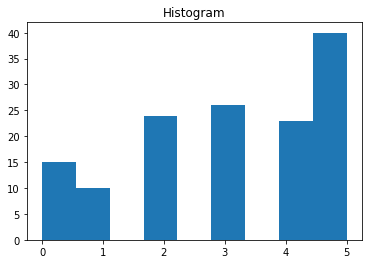

In [6]:
import matplotlib.pyplot as plt
_ = plt.hist(target_p_r, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram")
plt.show()

In [ ]:
from sklearn.feature_selection import GenericUnivariateSelect, chi2
X, y = data_p, target_p
print(X.shape)
transformer = GenericUnivariateSelect(chi2, 'k_best', param=100) #f_classif, chi2
X_new = transformer.fit_transform(X, y)
print(X_new.shape)

In [ ]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets, svm
from sklearn.feature_selection import SelectPercentile, f_classif

# #############################################################################
# Import some data to play with


# Add the noisy data to the informative features
from sklearn.preprocessing import Normalizer, StandardScaler

X = StandardScaler().fit_transform(data_p)
# X = data_p

cols_bool_nonzero = X.max(axis=0) > 0.0
print (cols_bool_nonzero.shape)

X = X.transpose()[cols_bool_nonzero].transpose()
y = target_p
print(X.shape)

plt.figure(1, figsize=(100, 10))
plt.clf()

X_indices = np.arange(X.shape[-1])/2.0


# #############################################################################
# Univariate feature selection with F-test for feature scoring
# We use the default selection function: the 10% most significant features
selector = SelectPercentile(f_classif, percentile=10)
selector.fit(X, y)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
plt.bar(X_indices + .05, scores, width=.1,
        label=r'Univariate score ($-Log(p_{value})$)', color='darkorange',
        edgecolor='black')

# #############################################################################
# Compare to the weights of an SVM
clf = svm.SVC(kernel='linear')
clf.fit(X, y)

svm_weights = (clf.coef_ ** 2).sum(axis=0)
svm_weights /= svm_weights.max()

plt.bar(X_indices + .15, svm_weights, width=.1, label='SVM weight',
        color='navy', edgecolor='black')

clf_selected = svm.SVC(kernel='linear')
clf_selected.fit(selector.transform(X), y)

svm_weights_selected = (clf_selected.coef_ ** 2).sum(axis=0)
svm_weights_selected /= svm_weights_selected.max()

plt.bar(X_indices[selector.get_support()] + .25, svm_weights_selected,
        width=.1, label='SVM weights after selection', color='c',
        edgecolor='black')


plt.title("Comparing feature selection")
plt.xlabel('Feature number')
plt.yticks(())
plt.axis('tight')
plt.legend(loc='upper right')
plt.savefig(folder_path + 'feature_selection', dpi=120)
plt.show()

In [ ]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.svm import SVC


# #############################################################################
# Import some data to play with
X, y = data_p, target_p
# #############################################################################
# Create a feature-selection transform, a scaler and an instance of SVM that we
# combine together to have an full-blown estimator
clf = Pipeline([('anova', SelectPercentile(chi2)),
                ('scaler', Normalizer()),
                ('svc', SVC(gamma="auto"))])

# #############################################################################
# Plot the cross-validation score as a function of percentile of features
score_means = list()
score_stds = list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    this_scores = cross_val_score(clf, X, y, cv=5)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

plt.errorbar(percentiles, score_means, np.array(score_stds))
plt.title(
    'Performance of the SVM-Anova varying the percentile of features selected')
plt.xticks(np.linspace(0, 100, 11, endpoint=True))
plt.xlabel('Percentile')
plt.ylabel('Accuracy Score')
plt.axis('tight')
plt.savefig(folder_path + 'svm-anova_norm', dpi=120)
plt.show()

In [ ]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


# #############################################################################
# Import some data to play with
X, y = data_p, target_p
# #############################################################################
# Create a feature-selection transform, a scaler and an instance of SVM that we
# combine together to have an full-blown estimator
clf = Pipeline([('anova', SelectPercentile(chi2)),
                ('scaler', StandardScaler()),
                ('svc', SVC(kernel='rbf', gamma="auto"))])

# #############################################################################
# Plot the cross-validation score as a function of percentile of features
score_means = list()
score_stds = list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    this_scores = cross_val_score(clf, X, y, cv=10)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

plt.errorbar(percentiles, score_means, np.array(score_stds))
plt.title(
    'Performance of the SVM-Anova varying the percentile of features selected', pad=10)
plt.xticks(np.linspace(0, 100, 11, endpoint=True))
plt.xlabel('Percentile')
plt.ylabel('Accuracy Score')
plt.axis('tight')
plt.savefig(folder_path + 'svm-anova_std', dpi=120, pad_inch=20)
plt.show()

Optimal number of features : 36


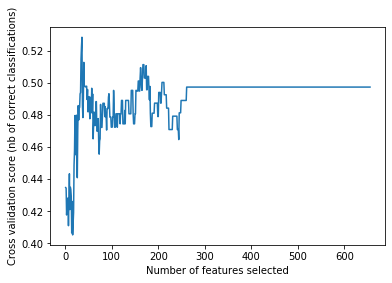

In [18]:
# need to run later

import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

X, y = data_p_p, target_p_p

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(10),
              scoring='accuracy')
rfecv.fit(X, y)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.savefig(folder_path + 'RFECV_kerlinear', dpi=120, pad_inch=20)
plt.show()

In [19]:
data_p_r.shape, data_p_p.shape

((138, 655), (138, 655))

In [25]:
## Cross Validation Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, datasets
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.metrics import classification_report
X, y = data_p_r[:,rfecv.support_], target_p_r
#X, y = data_p_r, target_p_r
print (X.shape, y.shape)
clf = RandomForestClassifier(n_estimators=100)
print (cross_validate(clf, X, y, scoring=['recall_macro', 'precision_macro', 'f1_macro', 'accuracy'], cv=5) )
y_pred = cross_val_predict(clf,X, y, cv=5 )
print(classification_report(y, y_pred))

(138, 36) (138,)


/home/vyasa/pythonEnv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/vyasa/pythonEnv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/vyasa/pythonEnv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/vyasa/pythonEnv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


{'fit_time': array([0.14630675, 0.10059071, 0.10640502, 0.08785963, 0.08982658]), 'score_time': array([0.02922559, 0.02835822, 0.02304435, 0.02250099, 0.02279234]), 'test_recall_macro': array([0.5       , 0.59166667, 0.66805556, 0.55416667, 0.65555556]), 'test_precision_macro': array([0.56684982, 0.60555556, 0.81388889, 0.55092593, 0.66666667]), 'test_f1_macro': array([0.5047619 , 0.58560606, 0.68614719, 0.55005942, 0.65357143]), 'test_accuracy': array([0.5862069 , 0.60714286, 0.67857143, 0.55555556, 0.65384615])}
              precision    recall  f1-score   support

           0       0.25      0.13      0.17        15
           1       1.00      0.90      0.95        10
           2       0.68      0.54      0.60        24
           3       0.61      0.54      0.57        26
           4       0.60      0.65      0.63        23
           5       0.57      0.78      0.66        40

    accuracy                           0.61       138
   macro avg       0.62      0.59      0.60   

In [ ]:
# Regression Feature Selection

import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_regression, mutual_info_regression

X = data_p
y = target_real_p

f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

feature_l = pd.read_csv(folder_path + 'dataset_LCPatient_fltrcols.csv').iloc[:,1:].columns.tolist()
print(feature_l[0:5])
print(len(feature_l))

mi = mutual_info_regression(X, y)
mi /= np.max(mi)



plt.figure(figsize=(25,300))
for i in range(X.shape[1]):
    plt.subplot(45, 5, i + 1)
    plt.scatter(X[:, i], y, edgecolor='black', s=20)
    plt.xlabel("${}$".format(feature_l[i]), fontsize=14)
    #plt.xlabel("$x_{}$".format(i+1), fontsize=14)
    if i == 0:
        plt.ylabel("$y$", fontsize=14)
    plt.title("F-test={:.2f}, MI={:.2f}".format(f_test[i], mi[i]),
              fontsize=12)
    if(f_test[i]>0.5 or mi[i]>0.5):
        print("feature={:40.40s} F-test={:.2f}, MI={:.2f}".format(feature_l[i],f_test[i], mi[i]))
plt.savefig(folder_path + 'f_regression, mutual_info_regression', dpi=120)
plt.show()

In [ ]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectPercentile, chi2, mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


# #############################################################################
# Import some data to play with
X, y = data_p, target_p
# #############################################################################
# Create a feature-selection transform, a scaler and an instance of SVM that we
# combine together to have an full-blown estimator
clf = Pipeline([('anova', SelectPercentile(mutual_info_classif)),
                ('scaler', StandardScaler()),
                ('svc', SVC(kernel='rbf', gamma="auto"))])

# #############################################################################
# Plot the cross-validation score as a function of percentile of features
score_means = list()
score_stds = list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    this_scores = cross_val_score(clf, X, y, cv=10)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

plt.errorbar(percentiles, score_means, np.array(score_stds))
plt.title(
    'Performance of the SVM-Anova varying the percentile of features selected', pad=10)
plt.xticks(np.linspace(0, 100, 11, endpoint=True))
plt.xlabel('Percentile')
plt.ylabel('Accuracy Score')
plt.axis('tight')
plt.savefig(folder_path + 'svm-anova_mutula_info_classif_std', dpi=120, pad_inch=20)
plt.show()

In [ ]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectPercentile, chi2, mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


# #############################################################################
# Import some data to play with
X, y = data_p, target_p
# #############################################################################
# Create a feature-selection transform, a scaler and an instance of SVM that we
# combine together to have an full-blown estimator
clf = Pipeline([('anova', SelectPercentile(mutual_info_classif)),
                ('scaler', StandardScaler()),
                ('svc', SVC(kernel='rbf', gamma="auto"))])

# #############################################################################
# Plot the cross-validation score as a function of percentile of features
score_means = list()
score_stds = list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    this_scores = cross_val_score(clf, X, y, cv=10)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

plt.errorbar(percentiles, score_means, np.array(score_stds))
plt.title(
    'Performance of the SVM-Anova varying the percentile of features selected', pad=10)
plt.xticks(np.linspace(0, 100, 11, endpoint=True))
plt.xlabel('Percentile')
plt.ylabel('Accuracy Score')
plt.axis('tight')
plt.savefig(folder_path + 'svm-anova_f_classif_std', dpi=120, pad_inch=20)
plt.show()

In [ ]:
# Feature Selection
import seaborn as sns
from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.feature_selection import RFE
# from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

# Need to include it future changes
df = pd.read_csv(folder_path + 'dataset_DementiaPatient_fltrcols_allfeatures.csv')
df = df.drop(columns=['patient_id'],axis=1)
display(df.head(5))

# Impute Values
simple_imputer =  SimpleImputer(strategy='median')
df_array = simple_imputer.fit_transform(df)
print (df_array.shape, np.count_nonzero(np.isnan(df_array)))
df = pd.DataFrame(data=df_array, columns=df.columns)

plt.figure(figsize=(100,100))
cor = df.corr()
#sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
#plt.show()
# Correlation with output variable
#cor_target = abs(cor["survivalMonths"])
cor_target = abs(cor["patient_class"])

# Selecting highly correlated features
relevant_features = cor_target[cor_target > 0.15]
print(relevant_features.sort_values(ascending=False))
print("{}".format('-'*80))

#cor_target = abs(cor["survivalMonthsCat"])

# Selecting highly correlated features
#relevant_features = cor_target[cor_target > 0.2]
#print(relevant_features)

In [ ]:
# feature selection for classification task

import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif 


df = pd.read_csv(folder_path + 'dataset_DementiaPatient_fltrcols_allfeatures.csv')
df = df.drop(columns=['patient_id'],axis=1)
display(df.head(5))

#impute missing values
simple_imputer =  SimpleImputer(strategy='median')
df_array = simple_imputer.fit_transform(df)
print (df_array.shape, np.count_nonzero(np.isnan(df_array)))
df = pd.DataFrame(data=df_array, columns=df.columns)


X = df.iloc[:,1:]  #independent columns
y = df.iloc[:,0:1].values.reshape(df.shape[0])  #target column i.e price range

print (X.shape, y.shape, type(X), type(y), y[0:10], X.columns)
#print (X[0:1], y[0:5])

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=mutual_info_classif, k=22)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(22,'Score'))  #print 10 best features'''


In [ ]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Build a classification task using 3 informative features
df = pd.read_csv(folder_path + 'dataset_DementiaPatient_fltrcols_allfeatures.csv')
df = df.drop(columns=['patient_id'],axis=1)
display(df.head(5))

# impute missing values
#impute missing values
simple_imputer =  SimpleImputer(strategy='median')
df_array = simple_imputer.fit_transform(df)
print (df_array.shape, np.count_nonzero(np.isnan(df_array)))
df = pd.DataFrame(data=df_array, columns=df.columns)



fea_list = df.columns[1:].tolist()
#print (fea_list)
X, y = data_p, target_p

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

#print (indices)
# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature: %s (%f)" % (f + 1, fea_list[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
'''plt.figure(figsize=(219,10))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center", width=0.1)
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()'''

In [ ]:
# Random Forest Feature Importance

print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

# Build a classification task using 3 informative features
df = pd.read_csv(folder_path + 'dataset_DementiaPatient_fltrcols_allfeatures.csv')
print (df.info())
df = df.drop(columns=['patient_id'],axis=1)
display(df.head(5))
fea_list = df.columns[1:].tolist()
#print(fea_list)
#print (fea_list)
X, y = data_p, target_p

# Build a forest and compute the feature importances
forest = RandomForestClassifier(n_estimators='warn',
                              random_state=0, bootstrap=False, criterion='gini',max_depth=5, max_features=100, min_samples_split=10)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

#print (indices)
# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature: %s (%f)" % (f + 1, fea_list[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
'''plt.figure(figsize=(219,10))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center", width=0.1)
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()'''
